<a href="https://colab.research.google.com/github/lqiang67/generative_models_examples/blob/main/VAE_2D_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

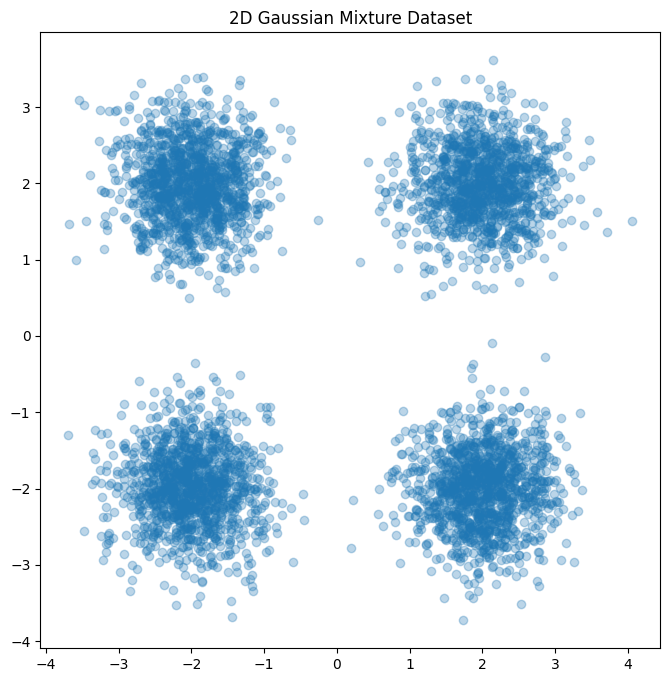

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal, kl_divergence

# Step 1: Create a 2D Toy Dataset
def generate_2d_gaussian_mixture(num_samples=1000):
    centers = [(-2, -2), (-2, 2), (2, -2), (2, 2)]
    cluster_std = 0.5

    data = []
    for i in range(num_samples):
        center = centers[np.random.choice(len(centers))]
        point = np.random.randn(2) * cluster_std + center
        data.append(point)

    return np.array(data, dtype=np.float32)

# Generate dataset
data_points = generate_2d_gaussian_mixture(5000)
dataset = data.TensorDataset(torch.tensor(data_points))
dataloader = data.DataLoader(dataset, batch_size=128, shuffle=True)


# Visualize the dataset
plt.figure(figsize=(8, 8))
plt.scatter(data_points[:, 0], data_points[:, 1], alpha=0.3)
plt.title('2D Gaussian Mixture Dataset')
plt.show()

Epoch 1, Loss: 5.325079549026489
Epoch 2, Loss: 2.9657885787963867
Epoch 3, Loss: 2.8276503189086912
Epoch 4, Loss: 2.7639070762634277
Epoch 5, Loss: 2.7433380973815917
Epoch 6, Loss: 2.676280754470825
Epoch 7, Loss: 2.6720621799468995
Epoch 8, Loss: 2.628940779876709
Epoch 9, Loss: 2.620967497634888
Epoch 10, Loss: 2.6427502376556395
Epoch 11, Loss: 2.60053099899292
Epoch 12, Loss: 2.6096556373596194
Epoch 13, Loss: 2.5801787841796875
Epoch 14, Loss: 2.5904003803253173
Epoch 15, Loss: 2.6135282066345216
Epoch 16, Loss: 2.600912526702881
Epoch 17, Loss: 2.5902825325012206
Epoch 18, Loss: 2.638205830383301
Epoch 19, Loss: 2.616816279602051
Epoch 20, Loss: 2.60538864402771
Epoch 21, Loss: 2.5973134449005126
Epoch 22, Loss: 2.6080559333801268
Epoch 23, Loss: 2.5438553085327147
Epoch 24, Loss: 2.6119791381835937
Epoch 25, Loss: 2.540505948638916
Epoch 26, Loss: 2.5834493442535402
Epoch 27, Loss: 2.560854864883423
Epoch 28, Loss: 2.59511167678833
Epoch 29, Loss: 2.594614221191406
Epoch 30, 

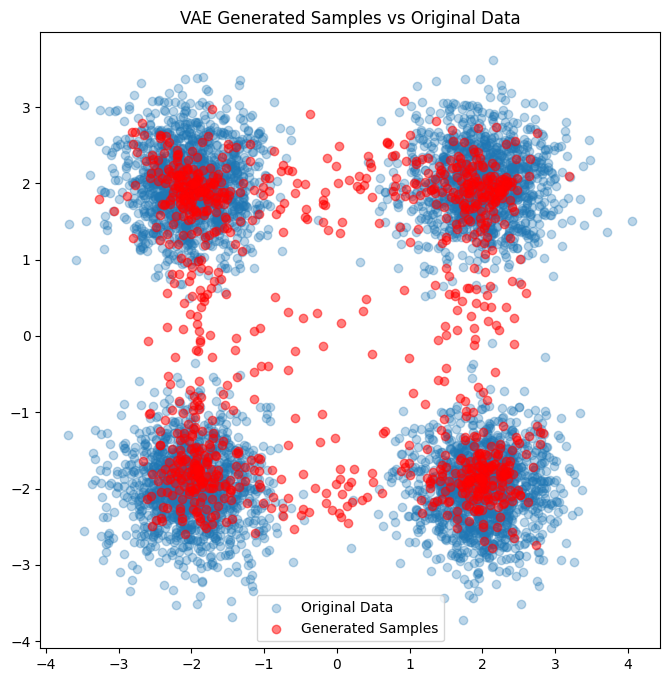

In [2]:
#@title: the VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, hidden_dim=128):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Step 3: Define the Loss Function
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div

# Step 4: Training the VAE
# Initialize the model, optimizer, and loss function
vae = VAE(input_dim=2, latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
vae.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader.dataset)}')

# Step 5: Visualize the Latent Space and Reconstruction
vae.eval()

# Sample latent points and decode
with torch.no_grad():
    z = torch.randn(1000, 2)
    samples = vae.decode(z).numpy()

# Plot original data
plt.figure(figsize=(8, 8))
plt.scatter(data_points[:, 0], data_points[:, 1], alpha=0.3, label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], color='red', alpha=0.5, label='Generated Samples')
plt.legend()
plt.title('VAE Generated Samples vs Original Data')
plt.show()
